### Description

In [80]:
### This code simulates examples to test some ideas such as:
## 1. Double check that normalising data does not affect model predictability
## 2. Double check KDE simulation is effective

### Imports

In [81]:
import pandas as pd

import numpy as np
from datetime import datetime
import xlsxwriter
import string
import os
import re
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy import stats
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
from sklearn.neighbors import KernelDensity
import seaborn as sns
import cvxpy as cp

### Principle component analysis

### Functions

In [82]:
def mpPDF(var,q,pts):
    # Marcenko-Pastur pdf
    # q=T/N
    eMin,eMax=var*(1-(1./q)**.5)**2,var*(1+(1./q)**.5)**2
    eVal=np.linspace(eMin,eMax,pts)
    pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
    #print(pdf)
    #print(type(pdf))
    #print(np.shape(pdf))
    #print(np.shape(np.reshape(pdf, newshape = 1000)))
    #print(q)
    #print(eVal)
    #print(len(pdf))
    
    pdf=pd.Series(np.reshape(pdf,1000),index=np.reshape(eVal,len(eVal))) ## necessary to reshape array from (R,1) to (R,)
    return pdf

def getPCA(matrix):
    # Get eVal,eVec from a Hermitian matrix
    eVal,eVec=np.linalg.eigh(matrix)
    indices=eVal.argsort()[::-1] # arguments for sorting eVal desc
    eVal,eVec=eVal[indices],eVec[:,indices]
    eVal=np.diagflat(eVal)
    return eVal,eVec
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def fitKDE(obs,bWidth=.25,kernel='gaussian',x=None):
    # Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated
    if len(obs.shape)==1:obs=obs.reshape(-1,1)
    kde=KernelDensity(kernel=kernel,bandwidth=bWidth).fit(obs)
    if x is None:x=np.unique(obs).reshape(-1,1)
    if len(x.shape)==1:x=x.reshape(-1,1)
    logProb=kde.score_samples(x) # log(density)
    pdf=pd.Series(np.exp(logProb),index=x.flatten())
    return pdf

def getRndCov(nCols,nFacts):
    w=np.random.normal(size=(nCols,nFacts))
    cov=np.dot(w,w.T) # random cov matrix, however not full rank
    cov+=np.diag(np.random.uniform(size=nCols)) # full rank cov
    return cov
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std=np.sqrt(np.diag(cov))
    corr=cov/np.outer(std,std)
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error
    return corr
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def errPDFs(var,eVal,q,bWidth,pts=1000):
    # Fit error
    pdf0=mpPDF(var,q,pts) # theoretical pdf
    pdf1=fitKDE(eVal,bWidth,x=pdf0.index.values) # empirical pdf
    sse=np.sum((pdf1-pdf0)**2)
    #return pdf0
    return sse
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def findMaxEval(eVal,q,bWidth):
    # Find max random eVal by fitting Marcenko’s dist
    #fun = errPDFs(x,eVal,q,bWidth)
    #out=minimize(fun(eVal,q,bWidth))
    out=minimize(lambda *x:errPDFs(*x),.5,args=(eVal,q,bWidth),bounds=((1E-5,1-1E-5),))
    if out['success']:
        var=out['x'][0]
    else:
        var=1
    eMax=var*(1+(1./q)**.5)**2
    return eMax,var

def denoisedCorr(eVal,eVec,nFacts):
    # Remove noise from corr by fixing random eigenvalues
    eVal_=np.diag(eVal).copy()
    eVal_[nFacts:]=eVal_[nFacts:].sum()/float(eVal_.shape[0]-nFacts)
    eVal_=np.diag(eVal_)
    corr1=np.dot(eVec,eVal_).dot(eVec.T)
    corr1=cov2corr(corr1)
    return corr1

def denoisedCorr2(eVal,eVec,nFacts,alpha=0):
# Remove noise from corr through targeted shrinkage
    eValL,eVecL=eVal[:nFacts,:nFacts],eVec[:,:nFacts]
    eValR,eVecR=eVal[nFacts:,nFacts:],eVec[:,nFacts:]
    corr0=np.dot(eVecL,eValL).dot(eVecL.T)
    corr1=np.dot(eVecR,eValR).dot(eVecR.T)
    corr2=corr0+alpha*corr1+(1-alpha)*np.diag(np.diag(corr1))
    return corr2

def formBlockMatrix(nBlocks,bSize,bCorr):
    block=np.ones((bSize,bSize))*bCorr
    block[range(bSize),range(bSize)]=1
    corr=block_diag(*([block]*nBlocks))
    return corr
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def formTrueMatrix(nBlocks,bSize,bCorr):
    corr0=formBlockMatrix(nBlocks,bSize,bCorr)
    corr0=pd.DataFrame(corr0)
    cols=corr0.columns.tolist()
    np.random.shuffle(cols)
    corr0=corr0[cols].loc[cols].copy(deep=True)
    std0=np.random.uniform(.05,.2,corr0.shape[0])
    cov0=corr2cov(corr0,std0)
    mu0=np.random.normal(std0,std0,cov0.shape[0]).reshape(-1,1)
    return mu0,cov0
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def corr2cov(corr,std):
    cov=corr*np.outer(std,std)
    return cov
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def deNoiseCov(cov0,q,bWidth):
    corr0=cov2corr(cov0)
    eVal0,eVec0=getPCA(corr0)
    eMax0,var0=findMaxEval(np.diag(eVal0),q,bWidth)
    nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)
    corr1=denoisedCorr(eVal0,eVec0,nFacts0)
    cov1=corr2cov(corr1,np.diag(cov0)**.5)
    return cov1

def simCovMu(mu0,cov0,nObs,shrink=False): # When shrink=True, the function performs a Ledoit–Wolf shrinkage of the empirical covariance matrix.
    x=np.random.multivariate_normal(mu0.flatten(),cov0,size=nObs)
    mu1=x.mean(axis=0).reshape(-1,1)-
    if shrink:cov1=LedoitWolf().fit(x).covariance_
    else:cov1=np.cov(x,rowvar=0)
    return mu1,cov1


def optPort(cov,mu=None):
    inv=np.linalg.inv(cov)
    ones=np.ones(shape=(inv.shape[0],1))
    if mu is None:mu=ones
    w=np.dot(inv,mu)
    w/=np.dot(ones.T,w)
    return w

In [85]:
#Suppose we have an mxn matrix with m measurements or indicators and n samples.
#Our plan is to recognize that any symmetric matrix A is diagonalized by an orthogonal matrix of its eigenvectors
# So if we construct a covariance matrix, then it will be diagonalised (thus preserving variance while eliminating covariance)
# we can perform PCA.

In [86]:
pricing_data_string = r"C:\Users\hugo.lu\repos\repos_backup\Strategy-creation\Raw data\EURUSD\2020-05-05_EURUSD_MIDPOINT_10 Y_1 day.csv"
pricing_data = pd.read_csv(filepath_or_buffer = pricing_data_string, index_col = 0)

In [103]:
x = pricing_data.loc[:,['close']].copy(deep = True)

In [104]:
var_list = []
for item in range(1,100):
    x['momentum_%s' % item] = (x['close']/x['close'].shift(item))-1
    var_list.append('momentum_%s' % item)
    

In [105]:
x_na = x.dropna()

In [106]:
x_na = x_na[var_list]
x_na.reset_index(inplace = True, drop = True)
x_na.head(2)

momentum_1  momentum_2  momentum_3  momentum_4  momentum_5  momentum_6  \
0    0.013387    0.006527    0.017265    0.033056    0.034006    0.031733   
1   -0.002853    0.010496    0.003655    0.014362    0.030108    0.031055   

   momentum_7  momentum_8  momentum_9  momentum_10  ...  momentum_90  \
0    0.037046    0.038123    0.047349     0.064201  ...     0.073365   
1    0.028789    0.034087    0.035161     0.044361  ...     0.087496   

   momentum_91  momentum_92  momentum_93  momentum_94  momentum_95  \
0     0.080629     0.086787     0.105780     0.088562     0.091755   
1     0.070302     0.077545     0.083686     0.102625     0.085456   

   momentum_96  momentum_97  momentum_98  momentum_99  
0     0.076447     0.069727     0.065629     0.055212  
1     0.088640     0.073376     0.066675     0.062589  

[2 rows x 99 columns]

In [108]:
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -

eVal0,eVec0=getPCA(np.corrcoef(x_na,rowvar=0))


In [110]:
## De mean data
x_demeaned = x_na - x_na.mean()

In [111]:
n= len(x_demeaned)

In [128]:
cx = np.array(x_demeaned.T)@(np.array(x_demeaned))/n

In [117]:
np.shape(eVec0) ##  the eigenvectors are in columns, so the first 99 rows = eigenvector for var 1

(99, 99)

In [129]:
eVec=np.linalg.eigh(cx)

In [130]:
np.shape(eVec[1])

(99, 99)

In [131]:
diagonal = eVec[1].T@cx@eVec[1]

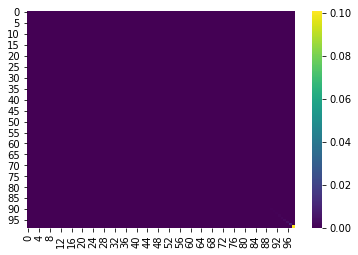

In [133]:
sns.heatmap(diagonal, cmap = "viridis")

In [138]:
check = (np.array(x_demeaned)@eVec[1])

In [139]:
check_covariance = check.T@check


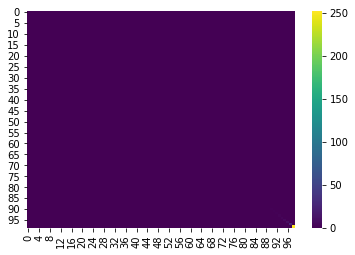

In [140]:
sns.heatmap(check_covariance, cmap = "viridis")

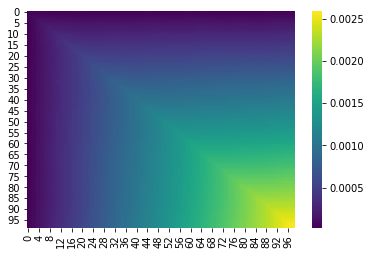

In [147]:
sns.heatmap(cx, cmap = "viridis")

In [ ]:
## So here we can see that by applying PCA we can get the eigenvectors of the covariance matrix. If we then apply these
## Eigenvectors as a linear transform to x, we can get a covariance matrix that focusses on the best point of signal. Now, 
## use monte carlo simulations to see what the best estimators are:h                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

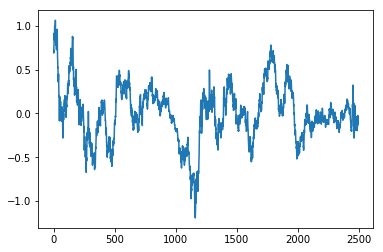

In [157]:
plt.plot(pd.DataFrame(check)[98])

In [160]:
np.shape(check[:,98])

(2494,)

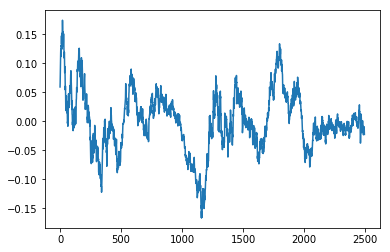

In [151]:
plt.plot(x_demeaned['momentum_99'])

# and indeed the correlation is high:
np.corrcoef(np.array(x_demeaned['momentum_99']),check[:,98])

### Functions

In [10]:
### Lasso

def loss_fn_lasso(X, Y, beta):
    return cp.norm2(X @ beta - Y)**2

def regularizer_lasso(beta):
    return cp.norm1(beta)

def objective_fn_lasso(X, Y, beta, lambd):
    return loss_fn_lasso(X, Y, beta) + lambd * regularizer_lasso(beta)

def mse_lasso(X, Y, beta):
    return (1.0 / X.shape[0]) * loss_fn_lasso(X, Y, beta).value

## Ridge

def loss_fn_ridge(X, Y, beta):
    return cp.pnorm(X @ beta - Y, p=2)**2

def regularizer_ridge(beta):
    return cp.pnorm(beta, p=2)**2

def objective_fn_ridge(X, Y, beta, lambd):
    return loss_fn_ridge(X, Y, beta) + lambd * regularizer_ridge(beta)

def mse_ridge(X, Y, beta):
    return (1.0 / X.shape[0]) * loss_fn_ridge(X, Y, beta).value


## Elastic net

def loss_fn_elastic_net(X, Y, beta):
    return cp.pnorm(Y - X @ beta , p=2)**2

def regularizer_elastic_net(beta,lambd,lambd2):
    return (lambd2)*cp.pnorm(beta, p=2)**2 + (lambd)*cp.norm1(beta) 


def objective_fn_elastic_net(X, Y, beta, lambd,lambd2):
    return loss_fn_elastic_net(X, Y, beta) + regularizer_elastic_net(beta,lambd,lambd2)

def mse_elastic_net(X, Y, beta):
    return (1.0 / X.shape[0]) * loss_fn_elastic_net(X, Y, beta).value





In [331]:
def plot_regularization_path(lambd_values, beta_values):
    num_coeffs = len(beta_values[0])
    for i in range(num_coeffs):
        plt.plot(lambd_values, [wi[i] for wi in beta_values])
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.xscale("log")
    plt.title("Regularization Path")
    plt.show()

def plot_train_test_errors(train_errors, test_errors, lambd_values):
    plt.plot(lambd_values, train_errors, label="Train error")
    plt.plot(lambd_values, test_errors, label="Test error")
    plt.xscale("log")
    plt.legend(loc="upper left")
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.title("Mean Squared Error (MSE)")
    plt.show()


## Test normalisation

In [378]:
X1 = np.random.normal(1,0.5,1000)
error = np.random.normal(0,3,1000)                 
X2 = 0.3*X1 

Y = 2*X1+error+0.2*X2+100
## Normalise 
Y = (Y - Y.mean())/Y.std()
X1 = (X1 - X1.mean())/X1.std()
X2 = (X2 - X2.mean())/X2.std()

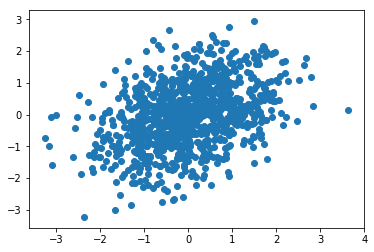

In [379]:
plt.scatter(X1,Y)

In [380]:
np.shape(X1)

(1000,)

In [381]:
np.shape(X)

(1000, 2)

In [382]:
X1 = np.reshape(X1, newshape = (len(X1),1))
X2 = np.reshape(X2, newshape = (len(X2),1))
X = np.hstack((X1,X2))
m = len(X)
n = 2

X_train = X[:int(m/2),:]
Y_train = Y[:int(m/2)]
X_test = X[int(m/2):,:]
Y_test = Y[int(m/2):]
alpha = 0
beta = cp.Variable(n)
lambd = cp.Parameter(nonneg=True)
lambd2 = cp.Parameter(nonneg=True)
print("a")
problem = cp.Problem(cp.Minimize(objective_fn_elastic_net(X_train, Y_train, beta, lambd,lambd2)))
print("b")
lambd_values = np.logspace(-2, 3, 50) ## Changing the lambda is equivalent to changing the t in order to observe different levels of regularisation
## alpha = l2/(l1+l2)
## so l2 = l1*alpha/(1-alpha)
lambd2_values = lambd_values*(alpha/(1-alpha))

train_errors = []
test_errors = []
beta_values = []
counter = 0
print("c")
for count,v in enumerate(lambd_values):
    lambd.value = v
    lambd2.value = lambd2_values[count]
    #print("Values remaining: " +str(len(lambd_values)-count))
    problem.solve()
    test_error = mse_elastic_net(X_test, Y_test, beta)
    train_errors.append(mse_elastic_net(X_train, Y_train, beta))
    test_errors.append(test_error)
    beta_values.append(beta.value)



opt_lambda = lambd_values[test_errors.index(min(test_errors))]
opt_beta = beta_values[test_errors.index(min(test_errors))]
y_pred = X_test@opt_beta
avg_ss = sum(((Y_test - Y_test.mean())**2)**(0.5))
pred_ss = sum(((Y_test - y_pred)**2)**(0.5))
r_squared = 1- (pred_ss/avg_ss)


a
b
c


In [383]:
opt_beta
## From this - we can see that the Lasso effectively recovers the coefficient although the regression is high due to the large 
## amount of noise

array([0.17366576, 0.17366576])

In [384]:
r_squared

0.0672858281786104

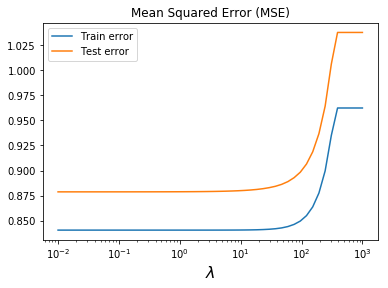

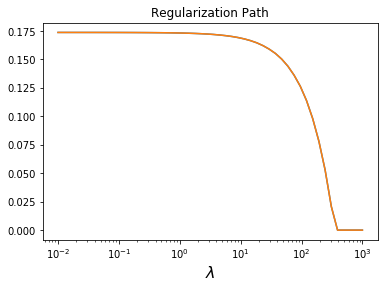

In [385]:
plot_train_test_errors(train_errors, test_errors, lambd_values)
plot_regularization_path(lambd_values, beta_values)

#### Test vs normalised variables

In [277]:
## Now, see if normalisation makes a difference
X1 = np.random.normal(10,0.5,10000
                    )
X2 = np.random.uniform(0,0.1,10000)
error = np.random.normal(0,0.4,10000)
Y = X1+0.2*X2
X1_mean = X1.mean()
X1_std = X1.std()
X2_mean = X2.mean()
X2_std = X2.std()
X1 = (X1-X1_mean)#/X1_std
X2 = (X2-X2_mean)#/X2_std
Y = Y - Y.mean()

In [278]:
X1 = np.reshape(X1, newshape = (len(X1),1))
X2 = np.reshape(X2, newshape = (len(X2),1))
X = np.hstack((X1,X2))
m = len(X)
n = 2

X_train = X[:int(m/2),:]
Y_train = Y[:int(m/2)]
X_test = X[int(m/2):,:]
Y_test = Y[int(m/2):]
alpha = 0
beta = cp.Variable(n)
lambd = cp.Parameter(nonneg=True)
lambd2 = cp.Parameter(nonneg=True)
print("a")
problem = cp.Problem(cp.Minimize(objective_fn_elastic_net(X_train, Y_train, beta, lambd,lambd2)))
print("b")
lambd_values = np.logspace(-2, 3, 50) ## Changing the lambda is equivalent to changing the t in order to observe different levels of regularisation
## alpha = l2/(l1+l2)
## so l2 = l1*alpha/(1-alpha)
lambd2_values = lambd_values*(alpha/(1-alpha))

train_errors = []
test_errors = []
beta_values = []
counter = 0
print("c")
for count,v in enumerate(lambd_values):
    lambd.value = v
    lambd2.value = lambd2_values[count]
    #print("Values remaining: " +str(len(lambd_values)-count))
    problem.solve()
    test_error = mse_elastic_net(X_test, Y_test, beta)
    train_errors.append(mse_elastic_net(X_train, Y_train, beta))
    test_errors.append(test_error)
    beta_values.append(beta.value)



opt_lambda = lambd_values[test_errors.index(min(test_errors))]
opt_beta = beta_values[test_errors.index(min(test_errors))]
y_pred = X_test@opt_beta
avg_ss = sum(((Y_test - Y_test.mean())**2)**(0.5))
pred_ss = sum(((Y_test - y_pred)**2)**(0.5))
r_squared = 1- (pred_ss/avg_ss)


a
b
c


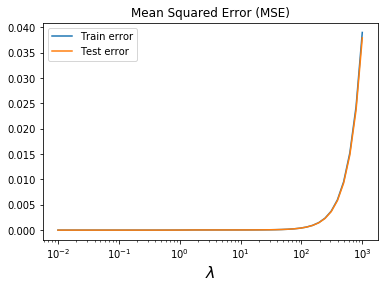

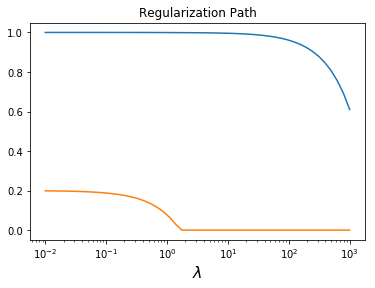

In [279]:
plot_train_test_errors(train_errors, test_errors, lambd_values)
plot_regularization_path(lambd_values, beta_values)

In [280]:
print(opt_beta)
print(r_squared)

[0.99999406 0.19877535]
0.9999241610144813


### Conclusion

In [ ]:
## Due to the need to regularise data before use, the lasso will fail if there is or are one of the following:
## 1. an normalised item
## 2. a constant relationship in the presence of nothing being normalised

## without normalisation, the propensity to under-fit the test set is very high. This is because the ability to 
## train well on the training set will be limited since there is no constant term to aid the Lasso. As the lambda
## term increases, the betas that are already struggling to work will be shrunk even further, so the model will
## just get worse.
## When these ill-fit parameters are applied on the test set, due to the inability to train properly, these may fit the
## test set even worse / better; but worse ex-hypothesi when the test and training set look similar.
## hence, as the lambdas increase, the model will become better at predicting since the parameters are so ill fit, 
## and the regularisaiton term also will decrease.

## The flow is: model misspecification causes inability to train on training set
## Ill-fitted parameters mean regularisation strictly decreases test set error through both dimensions (X/Y and reg.)


# Kernel density estimate

In [281]:
### This is going to test to see if KDE does actually accurately reproduce pricing data

In [283]:

    
file_path = r"C:\Users\hugo.lu\repos\repos_backup\Strategy-creation\cleaned_matrices\technical_indicator_clean.csv"
pricing_data_string = r"C:\Users\hugo.lu\repos\repos_backup\Strategy-creation\Raw data\EURUSD\2020-05-05_EURUSD_MIDPOINT_10 Y_1 day.csv"

In [284]:
pricing_data = pd.read_csv(filepath_or_buffer = pricing_data_string, index_col = 0)

In [291]:
close = pricing_data['close']
first_difference =(close- close.shift(1)).dropna()

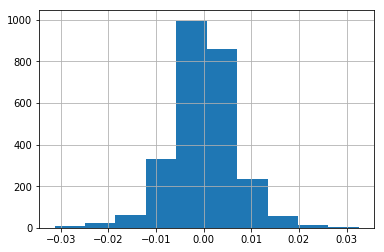

In [294]:
first_difference.hist()

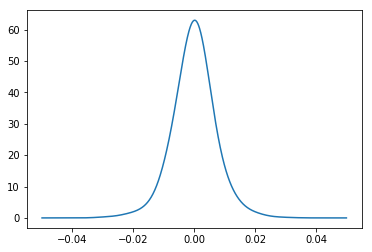

In [293]:

x = np.array(first_difference)
xs = np.linspace(-0.05,0.05,1000)
# expects n x p matrix with p features
x.shape = (len(x), 1)
xs.shape = (len(xs), 1)
#### Question@ is this the correct KDE to use? Probably can be refined and generalised....
kde = KernelDensity(bandwidth=0.003).fit(x)
dens = np.exp(kde.score_samples(xs))
plt.plot(xs, dens)


In [295]:
probs = dens / sum(dens)
xs_comma = np.reshape(xs,newshape = (len(xs),))

In [296]:
mc = np.random.choice(xs_comma, size=10000, replace=True, p=probs)

(array([3.000e+00, 1.100e+01, 1.800e+01, 3.500e+01, 7.000e+01, 1.490e+02,
        2.880e+02, 6.230e+02, 1.189e+03, 1.871e+03, 2.149e+03, 1.697e+03,
        1.010e+03, 4.810e+02, 2.170e+02, 1.120e+02, 3.900e+01, 2.700e+01,
        9.000e+00, 2.000e+00]),
 array([-0.03658659, -0.03306306, -0.02953954, -0.02601602, -0.02249249,
        -0.01896897, -0.01544545, -0.01192192, -0.0083984 , -0.00487487,
        -0.00135135,  0.00217217,  0.0056957 ,  0.00921922,  0.01274274,
         0.01626627,  0.01978979,  0.02331331,  0.02683684,  0.03036036,
         0.03388388]),
 <a list of 20 Patch objects>)

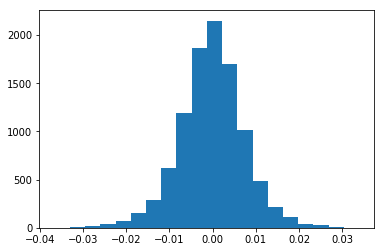

In [300]:
plt.hist(mc,bins = 20)

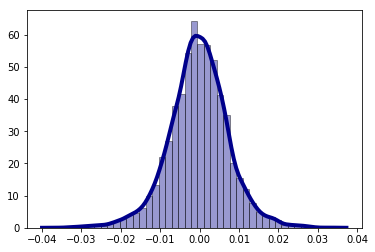

In [305]:
#Visualisation:
sns.distplot(mc, hist=True, kde=True, 
             bins=int(round((len(first_difference)/60))), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

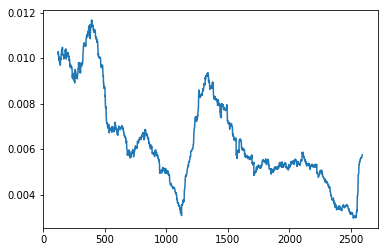

In [393]:
plt.plot(first_difference.rolling(120).std())

In [392]:
result = adfuller(first_difference)
    #print('ADF Statistic: %f' % result[0])
#print('p-value: %f' % result[1])
#print('Critical Values:')
#for key, value in result[4].items():
#    print('\t%s: %.3f' % (key, value))
if result[0] < -3.434:
    print("Stationary for: " )
    
else:
    print("Non stationary for: " )


Stationary for: 


In [394]:
#### although the parameters are changing significantly, it is not significant enough to reject stationarity.
result

(-51.68564000589435,
 0.0,
 0,
 2591,
 {'1%': -3.4328763567780456,
  '5%': -2.8626561482371278,
  '10%': -2.5673641660121183},
 -18347.333943882724)

In [397]:
forward_opportunity = close.rolling(21).max()
forward_opportunity = forward_opportunity.shift(-21)
forward_opportunity = forward_opportunity.dropna() 

In [398]:
result = adfuller(forward_opportunity)
    #print('ADF Statistic: %f' % result[0])
#print('p-value: %f' % result[1])
#print('Critical Values:')
#for key, value in result[4].items():
#    print('\t%s: %.3f' % (key, value))
if result[0] < -3.434:
    print("Stationary for: " )
    
else:
    print("Non stationary for: " )


Non stationary for: 


In [399]:
result

(-1.166282956572105,
 0.6879292288746389,
 11,
 2560,
 {'1%': -3.4329069801374077,
  '5%': -2.862669671881199,
  '10%': -2.5673713661193847},
 -22332.784690983186)

### Regularisation

In [1]:
## Consider a random numpy array

In [36]:
import numpy as np
import pandas as pd
import matplotlib as plt

In [62]:
array = np.random.normal(0,3,1000)

(array([ 11.,  28., 101., 175., 205., 255., 131.,  63.,  23.,   8.]),
 array([-8.8960871 , -7.03530575, -5.17452441, -3.31374306, -1.45296171,
         0.40781964,  2.26860098,  4.12938233,  5.99016368,  7.85094503,
         9.71172637]),
 <a list of 10 Patch objects>)

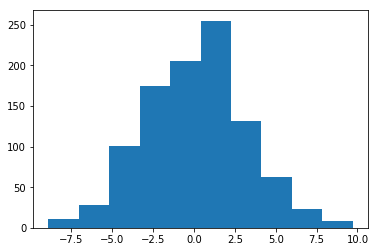

In [63]:
plt.pyplot.hist(array)

In [64]:
## Suppose we regularise, and then apply a function, and then regularise again

In [65]:
reg1 = (array - array.mean())/array.std()
#reg1 = reg1/array.std()

(array([ 11.,  28., 101., 175., 205., 255., 131.,  63.,  23.,   8.]),
 array([-2.90518971, -2.30246483, -1.69973996, -1.09701509, -0.49429021,
         0.10843466,  0.71115953,  1.31388441,  1.91660928,  2.51933416,
         3.12205903]),
 <a list of 10 Patch objects>)

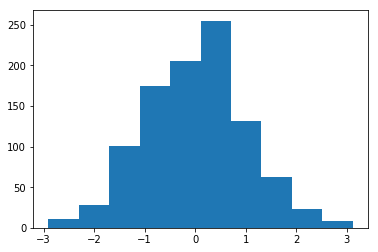

In [66]:
plt.pyplot.hist(reg1)

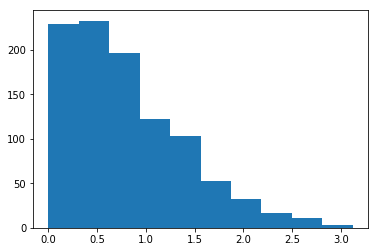

In [67]:
reg1 = pd.DataFrame(reg1)
reg1 = reg1.iloc[:,0]
reg1 = reg1.apply(lambda x: -x if x < 0 else x)
plt.pyplot.hist(reg1)
reg1 = (reg1 - reg1.mean())/reg1.std()


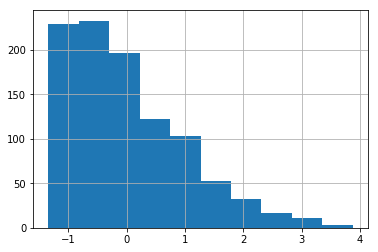

In [68]:
reg1.hist()

In [69]:
## Suppose instead, we apply the function first and then regularise
reg2 = array

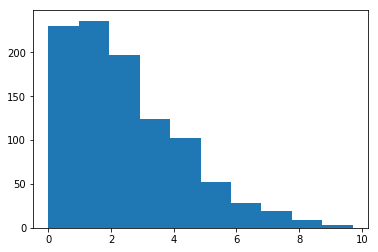

In [70]:
reg2 = pd.DataFrame(reg2)
reg2 = reg2.iloc[:,0]
reg2 = reg2.apply(lambda x: -x if x < 0 else x)
plt.pyplot.hist(reg2)
reg2 = (reg2 - reg2.mean())/reg2.std()

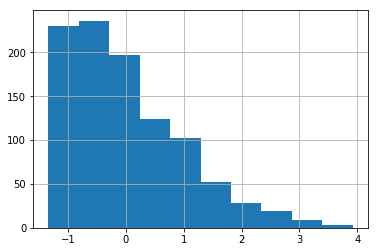

In [71]:
reg2.hist()

In [78]:
sum(np.absolute(reg1-reg2)) ## So the two are not equivalent.

39.018079459193345